# Inviscid and 1D Burgers' Equation

## 1. Finite Volume Method (FVM):

The spatial domain is divided into uniform cells of size $ \Delta x $, and the time is advanced using explicit time stepping.

####  Convective Term:  
The convective flux is $ f(u) = \frac{u^2}{2} $. We use a **Rusanov flux (local Lax-Friedrichs)** scheme for numerical stability:

$$
\hat{f}_{j+1/2} = \frac{1}{2} \left[f(u_j) + f(u_{j+1})\right] - \frac{1}{2} \alpha_{j+1/2} (u_{j+1} - u_j)
$$

where $\alpha_{j+1/2} = \max(|u_j|, |u_{j+1}|)$ is the local maximum wave speed.

####  Diffusive Term:
The diffusion is approximated using second-order central differences:

$$
\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{j+1} - 2u_j + u_{j-1}}{\Delta x^2}
$$

####  Time Stepping:
The timestep $ \Delta t $ is chosen using the **CFL condition** for stability:

$$
\Delta t = \frac{\text{CFL} \cdot \Delta x}{\max(|u|)}
$$

#### Algorithm:
At each time step:

1. Compute fluxes $f(u) = \frac{u^2}{2} $.

2. Compute numerical fluxes $\hat{f}_{j \pm 1/2}$ using Rusanov's scheme.

3. Compute diffusion using central differences.

4. Update $u_j$ using the conservative form:
   
$$
u_j^{n+1} = u_j^n - \frac{\Delta t}{\Delta x} (\hat{f}_{j+1/2} - \hat{f}_{j-1/2})
$$

5. Apply Dirichlet boundary conditions $u(−6) = u(6) = 0$.

6. Repeat until $t = t_\text{end}$.


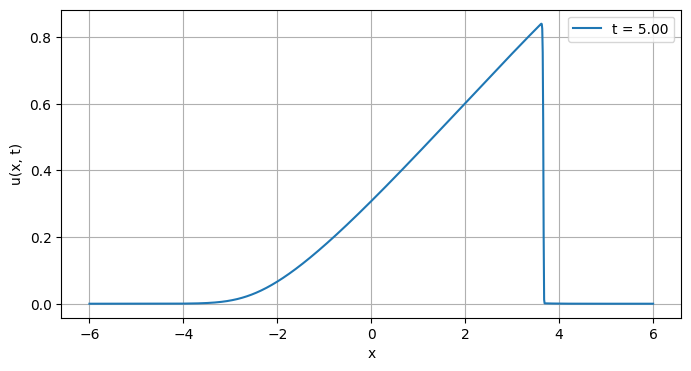

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters         
CFL = 0.4      
delta_x = 0.01     
nodes = 1200       
t_end = 5.0        

x = np.linspace(-6, 6, nodes + 1)

u = np.exp(-x**2 / 2)
t = 0.0

while t < t_end:
    
    u_max = np.max(np.abs(u))
    delta_t = CFL * delta_x / u_max

    f = u**2 / 2
    unext = np.copy(u)

    for j in range(1, nodes-2):
        alpha_plus = max(abs(u[j]), abs(u[j + 1]))
        f_hat_plus = 0.5 * (f[j] + f[j + 1]) - 0.5 * alpha_plus * (u[j + 1] - u[j])

        alpha_minus = max(abs(u[j - 1]), abs(u[j]))
        f_hat_minus = 0.5 * (f[j - 1] + f[j]) - 0.5 * alpha_minus * (u[j] - u[j - 1])

        unext[j] = (
            u[j]
            - (delta_t / delta_x) * (f_hat_plus - f_hat_minus)
        )

#Dirichlet Boundary Condition:
    unext[0] = 0.0       
    unext[-1] = 0.0

    u = unext.copy()
    t += delta_t


plt.figure(figsize=(8, 4))
plt.plot(x, u, label=f"t = {t:.2f}")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.grid()
plt.legend()
plt.show()


## 2. Physics-Informed Neural Networks (PINNs)


Physics-Informed Neural Networks (PINNs) are a deep learning framework where neural networks are trained to satisfy physical laws described by partial differential equations (PDEs), rather than relying solely on data. They incorporate the **PDE**, **initial conditions**, and **boundary conditions** into the training loss function.

This makes PINNs particularly powerful for solving forward or inverse problems involving differential equations, even with sparse or no training data.

### PINN Architecture

- Input: spatial and temporal coordinates \( (x, t) \)

- Output: approximation \( u(x, t) \)

- Network: Connected feedforward neural network (MLP) with `Tanh` activations. 

- Loss = PDE residual loss + Initial condition loss + Boundary condition loss



In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)


Using device: cuda


### Loss Components

The total loss function is a weighted sum of three parts:

#### 1. **PDE Residual Loss**
This ensures that the neural network output satisfies the Burgers’ equation at randomly sampled **collocation points**:

$$
\mathcal{L}_{\text{PDE}} = \left\| \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} \right\|^2
$$

In [21]:
def pde_residual(model, x, t):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    return u_t + u * u_x

#Parameters
layers = [2, 64, 64, 64, 1]
model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### 2. **Initial Condition Loss**
The initial condition:

$$
u(x, 0) = e^{-x^2 / 2}
$$

is a Gaussian pulse.

#### 3. **Boundary Condition Loss**
Dirichlet boundary conditions:

$$
u(-6, t) = u(6, t) = 0
$$

In [22]:
#Collocation points (interior of the domain)
N_f = 10000
x_f = torch.FloatTensor(N_f, 1).uniform_(-6, 6).to(device)
t_f = torch.FloatTensor(N_f, 1).uniform_(0, 5).to(device)

#Initial condition
N_ic = 200
x_ic = torch.linspace(-6, 6, N_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic)
u_ic = torch.exp(-((x_ic)**2)/2)

#Boundary conditions
N_bc = 200
t_bc = torch.linspace(0, 5, N_bc).reshape(-1, 1).to(device)
x_bc0 = -6 * torch.ones_like(t_bc)
x_bc1 =  6 * torch.ones_like(t_bc)
u_bc0 = torch.zeros_like(x_bc0)
u_bc1 = torch.zeros_like(x_bc1)

### Training

- **Collocation Points:** Randomly sampled in the interior of the spatio-temporal domain.

- **Initial Condition Points:** Uniformly sampled in space at $t = 0$.

- **Boundary Points:** Sampled in time at $x = -6$ and $x = 6$.

- **Optimizer:** Adam with learning rate $10^{-3}$.

- **Device:** GPU if available, otherwise CPU.

The neural network learns to satisfy the PDE and the initial/boundary conditions **without any labeled data** on the solution.

In [23]:
#Training
for epoch in range(100000):
    optimizer.zero_grad()

    #PDE loss (collocation points)
    f = pde_residual(model, x_f, t_f)
    loss_f = torch.mean(f**2)

    #Initial condition loss
    u_pred_ic = model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    #Boundary condition loss
    u_pred_bc0 = model(x_bc0, t_bc)
    u_pred_bc1 = model(x_bc1, t_bc)
    loss_bc = torch.mean((u_pred_bc0 - u_bc0)**2) + torch.mean((u_pred_bc1 - u_bc1)**2)

    #Total loss
    loss = loss_f + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

Epoch 0, Loss: 0.14814
Epoch 10000, Loss: 0.00079
Epoch 20000, Loss: 0.00053
Epoch 30000, Loss: 0.00055
Epoch 40000, Loss: 0.00002
Epoch 50000, Loss: 0.00000
Epoch 60000, Loss: 0.00000
Epoch 70000, Loss: 0.00001
Epoch 80000, Loss: 0.00000
Epoch 90000, Loss: 0.00000


### Output

After training, the predicted solution \( u(x, 5.0) \) is plotted to check the evolution of the initial Gaussian pulse.


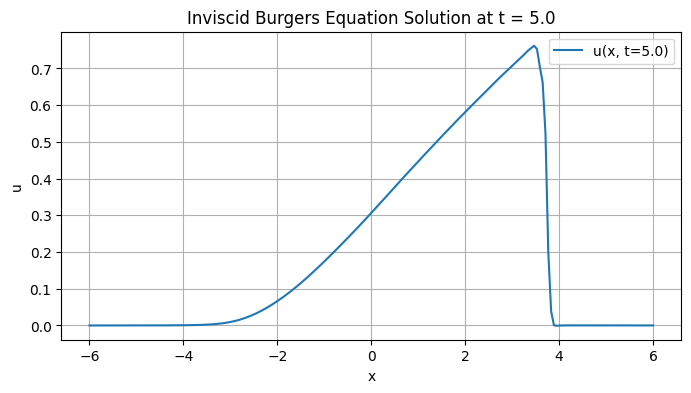

In [24]:
#u at t = 5
x_plot = torch.linspace(-6, 6, 200).reshape(-1, 1).to(device)
t_plot = 5.0 * torch.ones_like(x_plot)
u_plot = model(x_plot, t_plot).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_plot.cpu().numpy(), u_plot, label='u(x, t=5.0)')
plt.title('Inviscid Burgers Equation Solution at t = 5.0')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()
plt.show()